## Part 2. Data analysis and visualisation

Create a report in which you will include charts and briefly present your line of thinking. Write down assumptions you made, describe your methodology, e.g. how you filtered data etc. The report should be easy to understand for non-technical people. Name your report name_surname_analysis.pdf and include it as part of your final solution.

### Load data from the database

The first step to perform this task would be to generate csv files from the data in our database. In order not to share potentially sensitive data (as passwords), I created the *.env* file that contains the data allowing us to acces the *droptime* database. 

I load the data using the *mysql.connector* and save all the tables as separate csv files.

In [ ]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv('../../.env')

host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

tables = ['orders', 'products', 'orders_products', 'route_segments']

for table in tables:
    # check if the table already exists in data/
    if os.path.exists(f"../../data/{table}.csv"):
        print(f"File {table}.csv already exists. Skipping...")
        continue
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    df.to_csv(f"{table}.csv", index=False)
    print(f"File {table}.csv saved successfully.")

conn.close()

File orders.csv already exists. Skipping...
File products.csv already exists. Skipping...
File orders_products.csv already exists. Skipping...
File route_segments.csv already exists. Skipping...


I load the data and save it to separate DataFrames.

In [2]:
import pandas as pd

df_orders = pd.read_csv('../../data/orders.csv')
df_products = pd.read_csv('../../data/products.csv')
df_orders_products = pd.read_csv('../../data/orders_products.csv')
df_route_segments = pd.read_csv('../../data/route_segments.csv')

I check the data structure by printing samples from all DataFrames.

In [3]:
df_orders

,order_id,customer_id,sector_id,planned_delivery_duration
0,0,116,1,176
1,1,160,1,169
2,2,94,2,177
3,3,165,3,176
4,4,78,2,177
...,...,...,...,...
2235,2235,295,3,175
2236,2236,88,1,178
2237,2237,99,2,177
2238,2238,84,1,176


In [4]:
df_orders_products

,order_id,product_id,quantity
0,0,5,2
1,0,70,2
2,0,84,1
3,1,20,3
4,2,17,3
...,...,...,...
6734,2239,22,1
6735,2239,47,1
6736,2239,48,3
6737,2239,52,1


In [5]:
df_products

,product_id,weight
0,0,928
1,1,1533
2,2,833
3,3,1120
4,4,610
...,...,...
95,95,1491
96,96,464
97,97,761
98,98,1184


In [6]:
df_route_segments

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time
0,0,4,STOP,1312.0,2024-02-09 14:58:42,2024-02-09 15:01:56
1,1,4,DRIVE,NaN,2024-02-09 14:51:20,2024-02-09 14:55:42
2,2,4,STOP,1273.0,2024-02-24 09:26:31,2024-02-24 09:32:12
3,3,4,DRIVE,NaN,2024-02-24 09:15:02,2024-02-24 09:23:31
4,4,1,STOP,1036.0,2024-02-24 20:26:23,2024-02-24 20:26:23
...,...,...,...,...,...,...
4986,4986,4,STOP,1879.0,2024-02-20 19:16:17,2024-02-20 19:20:57
4987,4987,4,DRIVE,NaN,2024-02-20 19:07:52,2024-02-20 19:13:17
4988,4988,2,STOP,2053.0,2024-02-07 20:23:11,2024-02-07 20:25:10
4989,4989,2,DRIVE,NaN,2024-02-07 20:08:22,2024-02-07 20:20:11


### Preparing the data

The next step would be to find connections between particular DataFrames and merge them accordingly or create new tables basing on those.

I started by merging the *route_segments* table with the *orders* table. Those two have a common value - *order_id*. Now we can see all the infromation about the order in one, bigger table.

In [7]:
df_route_segments_orders = pd.merge(df_route_segments, df_orders, on="order_id", how="left")

In [8]:
df_route_segments_orders

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,customer_id,sector_id,planned_delivery_duration
0,0,4,STOP,1312.0,2024-02-09 14:58:42,2024-02-09 15:01:56,149.0,1.0,175.0
1,1,4,DRIVE,NaN,2024-02-09 14:51:20,2024-02-09 14:55:42,NaN,NaN,NaN
2,2,4,STOP,1273.0,2024-02-24 09:26:31,2024-02-24 09:32:12,228.0,3.0,177.0
3,3,4,DRIVE,NaN,2024-02-24 09:15:02,2024-02-24 09:23:31,NaN,NaN,NaN
4,4,1,STOP,1036.0,2024-02-24 20:26:23,2024-02-24 20:26:23,283.0,3.0,177.0
...,...,...,...,...,...,...,...,...,...
4986,4986,4,STOP,1879.0,2024-02-20 19:16:17,2024-02-20 19:20:57,43.0,1.0,178.0
4987,4987,4,DRIVE,NaN,2024-02-20 19:07:52,2024-02-20 19:13:17,NaN,NaN,NaN
4988,4988,2,STOP,2053.0,2024-02-07 20:23:11,2024-02-07 20:25:10,129.0,3.0,180.0
4989,4989,2,DRIVE,NaN,2024-02-07 20:08:22,2024-02-07 20:20:11,NaN,NaN,NaN


We can check how many rows we have on each *segment_type*.

In [9]:
len(df_route_segments_orders[df_route_segments_orders['segment_type'] == 'STOP'].isna().any(axis=1))

2751

In [10]:
len(df_route_segments_orders[df_route_segments_orders['segment_type'] == 'DRIVE'].isna().any(axis=1))

2240

We can see that there are several rows with missing data (marked as *NaN*). We are not supposed to make any assumptions, but it is crutial to understand this data. Segments can be described as parts of the drivers route. What interests us is the "STOP" segment, meaning the moment when the drivers stops in order to deliver the order to the client.

The most important for us is the delivery time, so the columns *segmanet_start_time* and *segment_end_time* columns. Those are the most crutial for us to create the visualizations, so we will check if iin any of the rows we can find missing data.

In [11]:
missing_start = df_route_segments_orders['segment_start_time'].isnull().sum()
print(f"Missing segment_start_time: {missing_start}")   
missing_end = df_route_segments_orders['segment_end_time'].isnull().sum()
print(f"Missing segment_end_time: {missing_end}")

Missing segment_start_time: 0
Missing segment_end_time: 0


In order to perform any operations on those columns we will have to change their datatype to *datetime*, which allows us to perform time operations on data.

In [13]:
df_route_segments_orders['segment_start_time'] = pd.to_datetime(df_route_segments_orders['segment_start_time'])
df_route_segments_orders['segment_end_time'] = pd.to_datetime(df_route_segments_orders['segment_end_time'])

We verify whether the operation worked correctly.

In [14]:
df_route_segments_orders.dtypes

segment_id                            int64
driver_id                             int64
segment_type                         object
order_id                            float64
segment_start_time           datetime64[ns]
segment_end_time             datetime64[ns]
customer_id                         float64
sector_id                           float64
planned_delivery_duration           float64
dtype: object

The main objective of this task is to see how much does the actual delivery time differ from the predicted delivery time. In order to create the *actual_delivery_time* column we have to simply substract the *segment_start_time* from the *segment_end_time*. We add this column to our dataframe and round the result to the whole minutes.

In [15]:
stops_df = df_route_segments_orders[df_route_segments_orders['segment_type'] == 'STOP'].copy()

stops_df['actual_delivery_duration'] = (stops_df['segment_end_time'] - stops_df['segment_start_time']).dt.total_seconds() / 60
stops_df['actual_delivery_duration'] = stops_df['actual_delivery_duration'].apply(lambda x: round(x))


As some of the values are missing, it may raise some errors. In order to execute the code whithout them, we need to assure us that we will only be processing the non-null (not missing) data. We can see that in the original data, the predicted delivery time is given in seconds. It is not really intuitive for humans' thinking, so we will cast it to minutes.

In [16]:
for index, row in stops_df.iterrows():
    if pd.notnull(row['planned_delivery_duration']):
        stops_df.at[index, 'planned_delivery_duration'] = int(round(row['planned_delivery_duration'] / 60))
        

Finally, we check the structure of our data.

In [17]:
stops_df 

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,customer_id,sector_id,planned_delivery_duration,actual_delivery_duration
0,0,4,STOP,1312.0,2024-02-09 14:58:42,2024-02-09 15:01:56,149.0,1.0,3.0,3
2,2,4,STOP,1273.0,2024-02-24 09:26:31,2024-02-24 09:32:12,228.0,3.0,3.0,6
4,4,1,STOP,1036.0,2024-02-24 20:26:23,2024-02-24 20:26:23,283.0,3.0,3.0,0
6,6,1,STOP,NaN,2024-02-24 20:03:27,2024-02-24 20:20:43,NaN,NaN,NaN,17
7,7,2,STOP,2178.0,2024-02-23 09:39:03,2024-02-23 09:40:47,234.0,3.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...
4982,4982,3,STOP,564.0,2024-02-10 06:07:03,2024-02-10 06:09:20,6.0,2.0,3.0,2
4984,4984,4,STOP,1373.0,2024-02-20 16:08:08,2024-02-20 16:17:15,12.0,1.0,3.0,9
4986,4986,4,STOP,1879.0,2024-02-20 19:16:17,2024-02-20 19:20:57,43.0,1.0,3.0,5
4988,4988,2,STOP,2053.0,2024-02-07 20:23:11,2024-02-07 20:25:10,129.0,3.0,3.0,2


## Visualizations

#### 1. Histogram of the actual delivery time (1-minute granularity)

As the actual delivery time has already been calculated, we can now simply visualize the results.

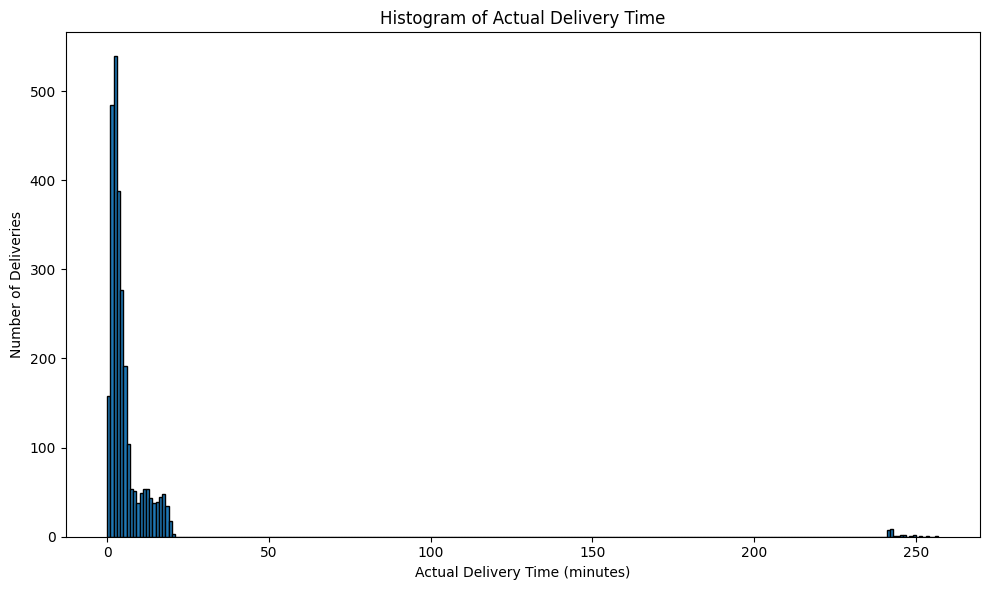

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(stops_df['actual_delivery_duration'], bins=range(0, int(stops_df['actual_delivery_duration'].max()) + 2), edgecolor='black')
plt.title('Histogram of Actual Delivery Time')
plt.xlabel('Actual Delivery Time (minutes)')
plt.ylabel('Number of Deliveries')
plt.tight_layout()
plt.show()

In order to visualize the dominant data in more accesible way, we can limit the x-axis to show values only from -20 to 20.

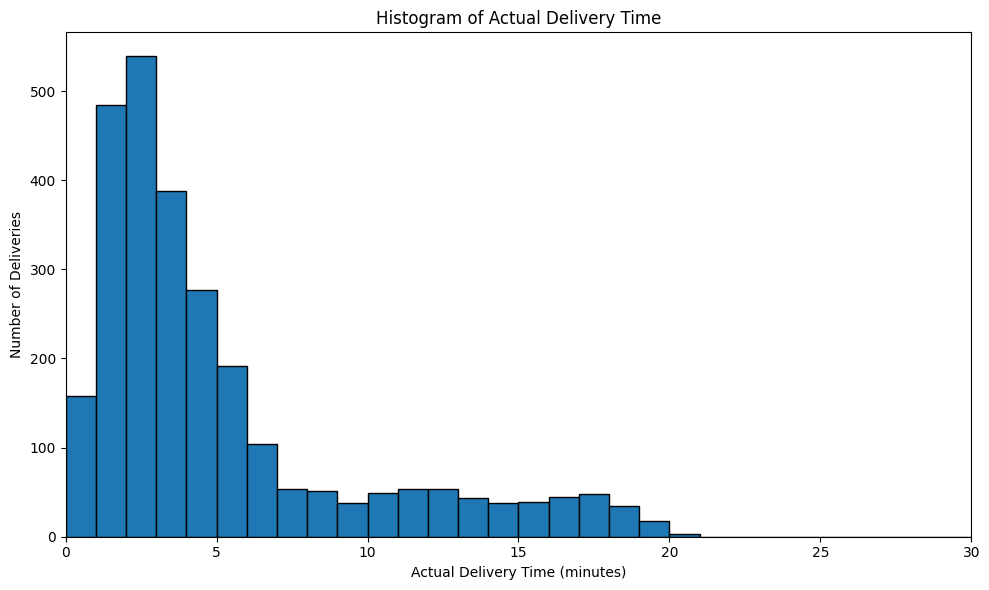

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(stops_df['actual_delivery_duration'], bins=range(0, int(stops_df['actual_delivery_duration'].max()) + 2), edgecolor='black')
plt.title('Histogram of Actual Delivery Time')
plt.xlabel('Actual Delivery Time (minutes)')
plt.ylabel('Number of Deliveries')
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

We can see that there are a few outliares (values signifficantly far from the rest of the data) in our plot. 
Even though the outlier values seem veirdly inacurate, there a situations when the delivery can tale even up to 250 minutes (above 4 hours). We should not be making any asumptions then.

Thankfully, most of the orders are delivered under 20 minutes, what is absolutelly normal. 

#### 2. Histogram of the prediction error

Prediction error is simply the difference between the planned delivery time and actual delivery time. We just need to substract the values in the *planned_delivery_time* and *actual_delivery_time* and then visualiz them.

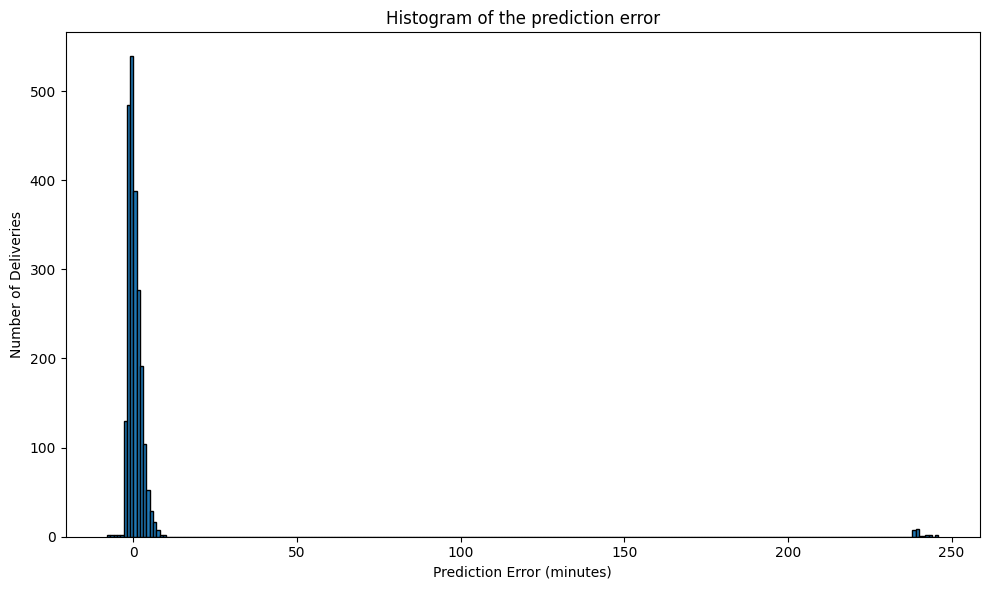

In [20]:
import matplotlib.pyplot as plt
stops_df['prediction_error'] = stops_df['actual_delivery_duration'] - stops_df['planned_delivery_duration']

plt.figure(figsize=(10,6))
plt.hist(stops_df['prediction_error'], bins=range(int(stops_df['prediction_error'].min()), 
                                                  int(stops_df['prediction_error'].max()) + 1), edgecolor='black')
plt.title('Histogram of the prediction error')
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Number of Deliveries')
plt.tight_layout()
plt.show()

In case of most of the deliveries the error seems to be relatively small (oscilating from around -10 to 10 minutes). Even though we cannot speak of time as of negative values, in this case it simply means that the delivery has been delivered before the predicted time.

As in the previous example, there are deliveries late by around 4 hours. These kinds of events can occure, so again, it should not be considered an error.

However, we can print and verify the negative values, as well as values oscilating around 200 minutes.

In [21]:
print(len(stops_df[stops_df['prediction_error'] > 200]))
stops_df[stops_df['prediction_error'] > 200]

24


,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,customer_id,sector_id,planned_delivery_duration,actual_delivery_duration,prediction_error
400,400,2,STOP,461.0,2024-02-08 15:22:20,2024-02-08 19:24:01,253.0,2.0,3.0,242,239.0
656,656,4,STOP,636.0,2024-02-23 04:33:08,2024-02-23 08:40:47,10.0,1.0,3.0,248,245.0
949,949,4,STOP,734.0,2024-02-08 02:23:51,2024-02-08 06:28:43,251.0,2.0,3.0,245,242.0
1055,1055,1,STOP,149.0,2024-02-02 09:01:03,2024-02-02 13:02:02,42.0,3.0,3.0,241,238.0
1169,1169,4,STOP,1020.0,2024-02-18 21:38:59,2024-02-19 01:41:52,64.0,2.0,3.0,243,240.0
1772,1772,4,STOP,7.0,2024-02-13 08:44:16,2024-02-13 12:50:03,179.0,3.0,3.0,246,243.0
1778,1778,4,STOP,941.0,2024-02-26 04:18:26,2024-02-26 08:22:57,48.0,1.0,3.0,245,242.0
1907,1907,2,STOP,1606.0,2024-02-06 16:07:11,2024-02-06 20:08:48,305.0,3.0,3.0,242,239.0
1919,1919,2,STOP,1356.0,2024-02-15 07:18:48,2024-02-15 11:20:51,293.0,1.0,3.0,242,239.0
1964,1964,4,STOP,1182.0,2024-02-04 16:33:00,2024-02-04 20:35:18,104.0,2.0,3.0,242,239.0


In [22]:
# print the rows where the error is smaller than 
stops_df[stops_df['prediction_error'] < 0]

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,customer_id,sector_id,planned_delivery_duration,actual_delivery_duration,prediction_error
4,4,1,STOP,1036.0,2024-02-24 20:26:23,2024-02-24 20:26:23,283.0,3.0,3.0,0,-3.0
7,7,2,STOP,2178.0,2024-02-23 09:39:03,2024-02-23 09:40:47,234.0,3.0,3.0,2,-1.0
12,12,1,STOP,2221.0,2024-02-16 04:37:40,2024-02-16 04:40:06,284.0,1.0,3.0,2,-1.0
17,17,2,STOP,1469.0,2024-02-02 07:06:35,2024-02-02 07:06:35,122.0,3.0,3.0,0,-3.0
19,19,2,STOP,1461.0,2024-02-02 21:06:43,2024-02-02 21:08:58,211.0,3.0,3.0,2,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
4969,4969,3,STOP,572.0,2024-02-19 19:47:28,2024-02-19 19:49:57,11.0,2.0,3.0,2,-1.0
4972,4972,1,STOP,1950.0,2024-02-18 18:31:46,2024-02-18 18:32:46,187.0,1.0,3.0,1,-2.0
4978,4978,2,STOP,252.0,2024-02-23 04:22:17,2024-02-23 04:24:46,167.0,3.0,3.0,2,-1.0
4982,4982,3,STOP,564.0,2024-02-10 06:07:03,2024-02-10 06:09:20,6.0,2.0,3.0,2,-1.0


Again, in order to visualize the dominant data in more accesible way, we can limit the x-axis to show values only from -20 to 20.

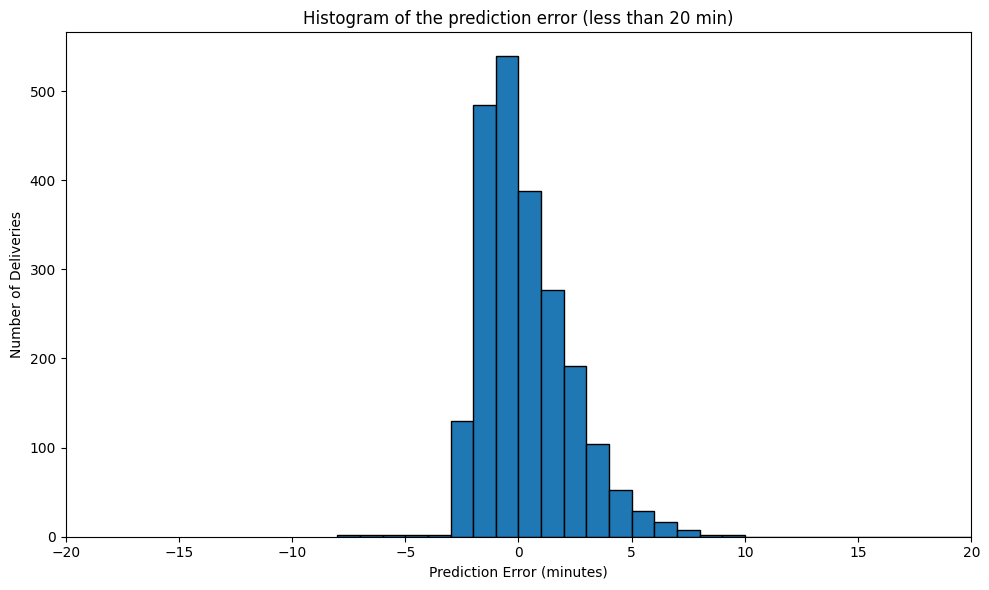

In [23]:
plt.figure(figsize=(10,6))
plt.hist(stops_df[stops_df['prediction_error'] < 20]['prediction_error'], 
         bins=range(int(stops_df['prediction_error'].min()), 
                    int(stops_df['prediction_error'].max()) + 1), edgecolor='black')
plt.title('Histogram of the prediction error (less than 20 min)')
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Number of Deliveries')
plt.xlim(-20, 20)
plt.tight_layout()

Now it can be clearly seen that most orders are delivered in time or more or less 10 minutes after the predicted delivery time. Some of them arrive even before predicted.

### 3. Average delivery time between sectors 

Drivers state that delivering in one of the sectors is significantly longer than in other sectors. We can create a barplot that will show us the average delivery time in order to check this hipotesis.

In order to do that we need to group the data and calculate the average delivery time in every sector.

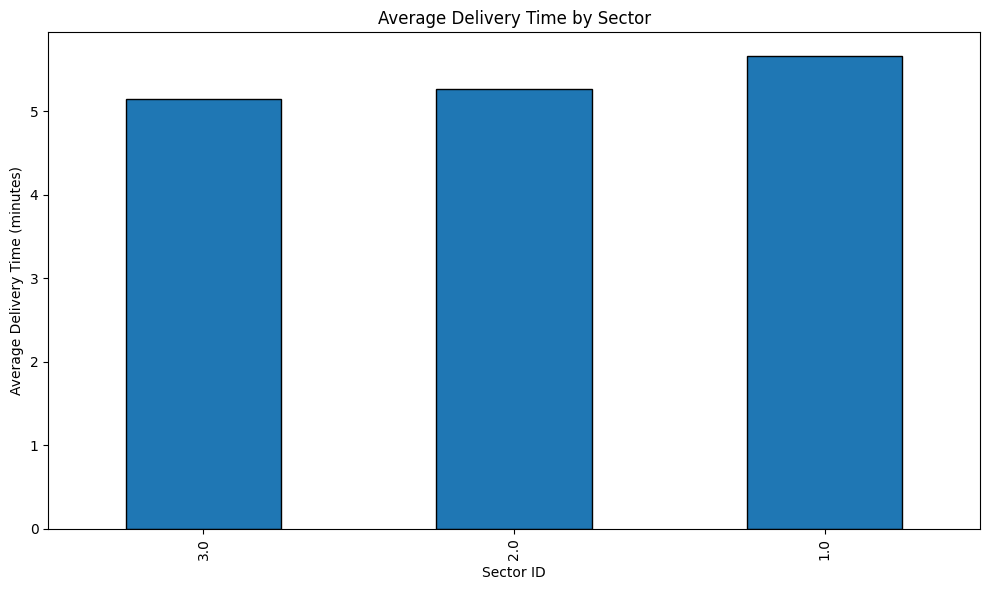

In [24]:
sector_delivery_time = stops_df.groupby('sector_id')['actual_delivery_duration'].mean().sort_values()

plt.figure(figsize=(10,6))
sector_delivery_time.plot(kind='bar', edgecolor='black')
plt.title('Average Delivery Time by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Average Delivery Time (minutes)')
plt.tight_layout()
plt.show()

It is true that the average delivery time in the third sector seems to take longer than in the other two. However, I would not call it the *signifficant difference*, as the diagram shows that the time difference is less than 1-minute.  

### 4. Additional analysis

#### 4.1. Delivery time according to drivers

We cheked the delivery duration among sectors, so the logical thing would be to do the same among drivers.

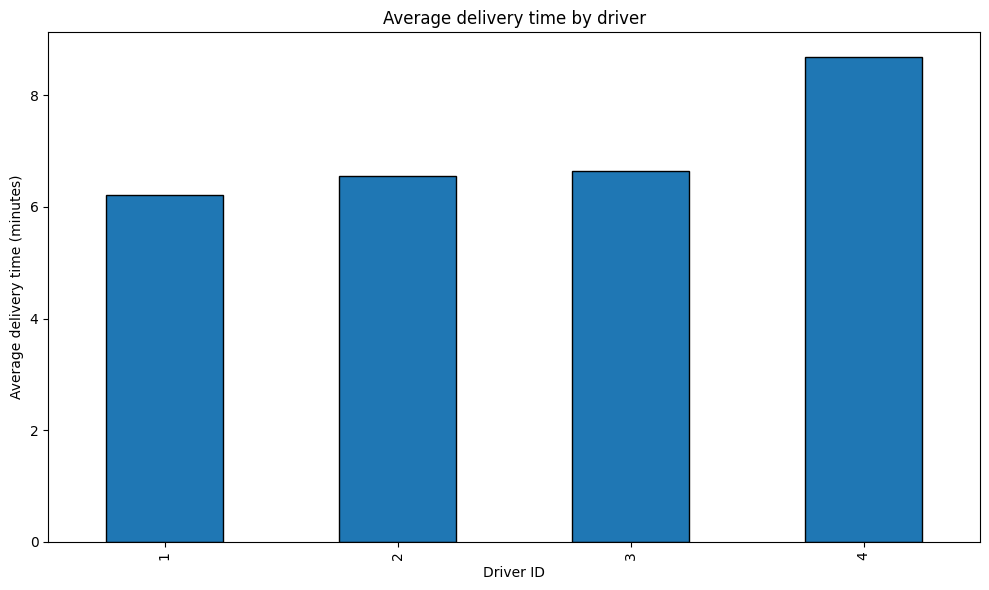

In [25]:
# Średni czas dostawy w różnych sektorach
driver_delivery_time = stops_df.groupby('driver_id')['actual_delivery_duration'].mean().sort_values()

# Wykres porównujący czas dostawy na sektorach
plt.figure(figsize=(10,6))
driver_delivery_time.plot(kind='bar', edgecolor='black')
plt.title('Average delivery time by driver')
plt.xlabel('Driver ID')
plt.ylabel('Average delivery time (minutes)')
plt.tight_layout()
plt.show()

Now we can see that the driver with *driver_id* 4 needs significantly more time to deliver the orders.

#### 4.2. Average delivery time per sector and per driver

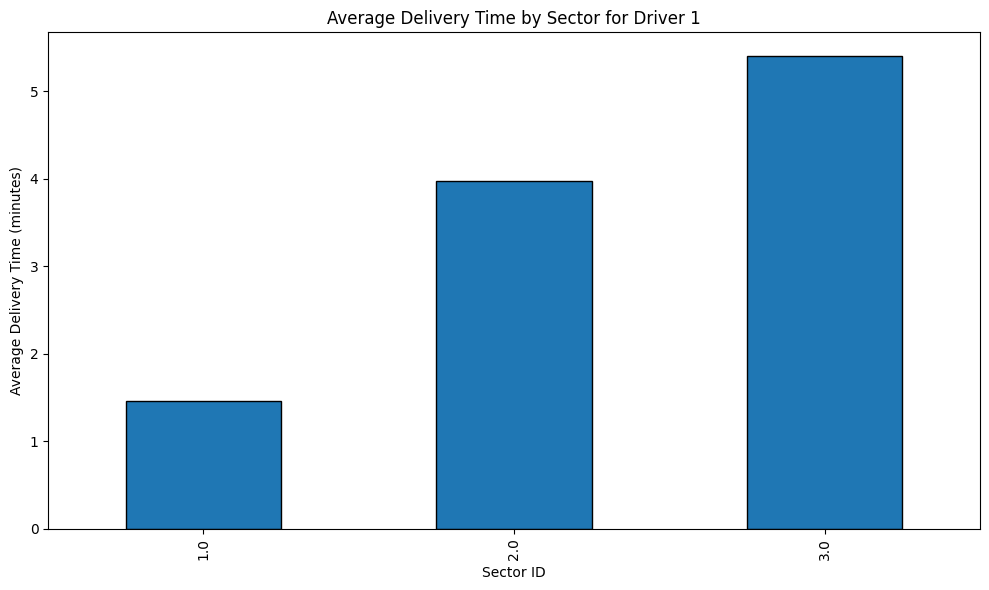

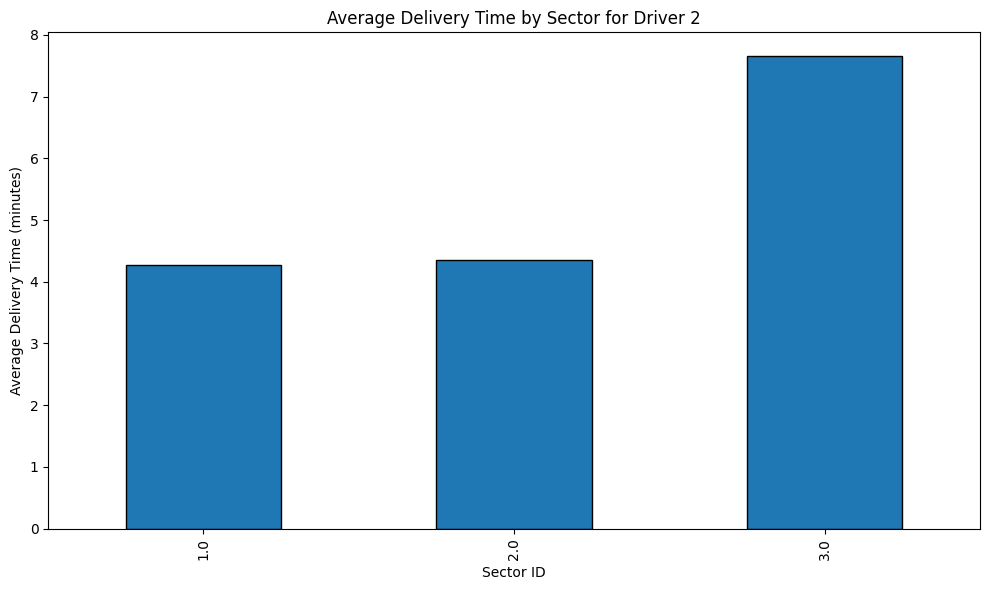

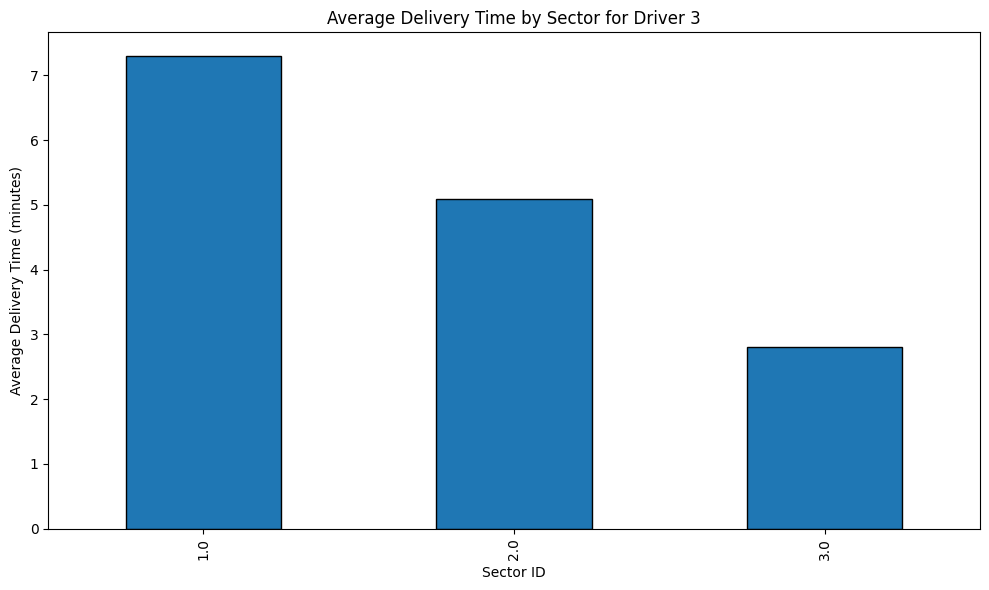

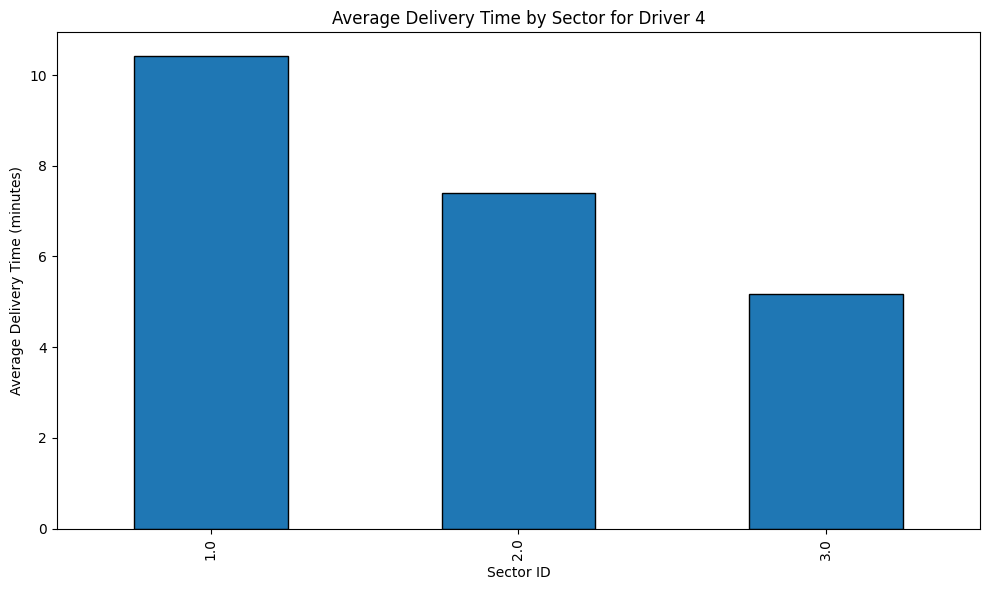

In [26]:
for driver_id in sorted(stops_df['driver_id'].unique()):
    driver_data = stops_df[stops_df['driver_id'] == driver_id]
    sector_delivery_time = driver_data.groupby('sector_id')['actual_delivery_duration'].mean().sort_index()

    plt.figure(figsize=(10,6))
    sector_delivery_time.plot(kind='bar', edgecolor='black')
    plt.title(f'Average Delivery Time by Sector for Driver {driver_id}')
    plt.xlabel('Sector ID')
    plt.ylabel('Average Delivery Time (minutes)')
    plt.tight_layout()
    plt.show()

Further analysis shows that taking into account the delivery time, the only stable sector is the second one.

Drivers 1 and 2 need significanly more time to deliver in sector 3, whereas drivers 3 and 4 need take more time in sector 1.

#### 4.3. Average delivery time vs order weight

In order to perform this and some other analysis we will need information about total order weight and total cuantity of ordered products. We will aggregate the data in order to retrive this info.

I devided the data according to the following:
- orders of *total_weight* < 2kg are considered small
- those between 2kg and 5kg are considers medium
- orders above 5kg are considered large

In [27]:
df_orders_products['total_weight'] = df_orders_products['quantity'] * df_products['weight']

agg_weights = df_orders_products.groupby('order_id').agg(
    total_weight=('total_weight', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()

stops_df = stops_df.merge(agg_weights, on='order_id', how='left')

C:\Users\48726\AppData\Local\Temp\ipykernel_16372\3250387873.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_avg = stops_df.groupby('order_size')['actual_delivery_duration'].mean().reset_index()


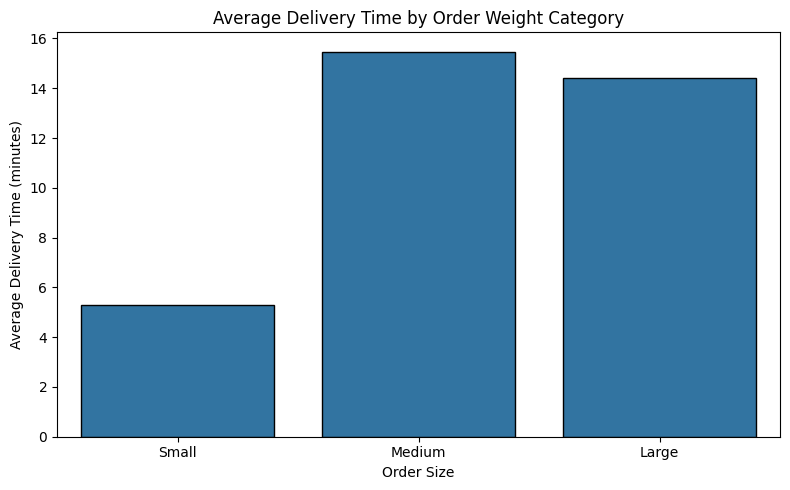

In [36]:
import seaborn as sns

def categorize_order(row):
    if row['total_weight'] < 4000:
        return 'Small'
    elif row['total_weight'] < 12000:
        return 'Medium'
    else:
        return 'Large'

stops_df['order_size'] = stops_df.apply(categorize_order, axis=1)

stops_df['order_size'] = pd.Categorical(
    stops_df['order_size'],
    categories=['Small', 'Medium', 'Large'],
    ordered=True
)

size_avg = stops_df.groupby('order_size')['actual_delivery_duration'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=size_avg, x='order_size', y='actual_delivery_duration', order=['Small', 'Medium', 'Large'], edgecolor='black')
plt.title('Average Delivery Time by Order Weight Category')
plt.xlabel('Order Size')
plt.ylabel('Average Delivery Time (minutes)')
plt.tight_layout()
plt.show()


We can clearly see that large orders take signifficantly more time to be delivered. However, it does not mean that small orders would take littlest time to be delivered, because they take more time than the medium ones.

It might mean that the order weight does not really influence the delivery time, at least when it comes to small and medium orders.

Other thing we can check is the correlation between delivery time and order weight, visualizing this data on a scatterplot.

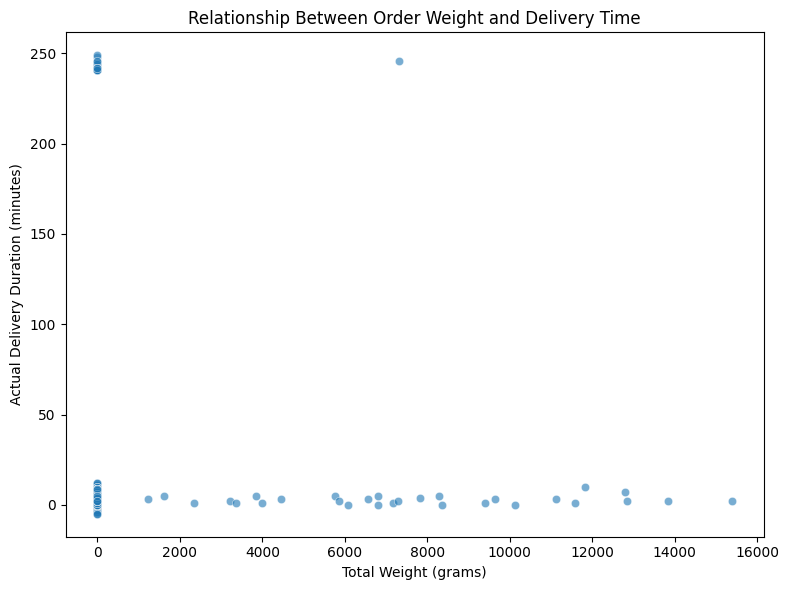

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=stops_df,
    x='total_weight',
    y='actual_delivery_duration',
    alpha=0.6
)
plt.title('Relationship Between Order Weight and Delivery Time')
plt.xlabel('Total Weight (grams)')
plt.ylabel('Actual Delivery Duration (minutes)')
plt.tight_layout()
plt.show()


#### 4.4. Average delivery time during the week

In order to visualize this correlation, we need to extract the day of the week from the *segment_start_time* and then cast the data to the actual days' names.

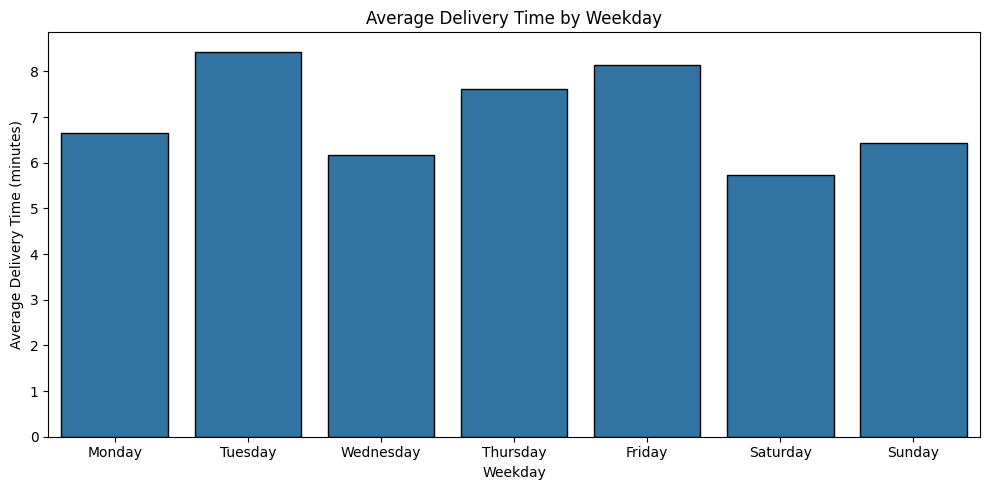

In [30]:
stops_df['weekday'] = stops_df['segment_start_time'].dt.day_name()

weekday_avg = stops_df.groupby('weekday')['actual_delivery_duration'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_avg, x='weekday', y='actual_delivery_duration', edgecolor='black')
plt.title('Average Delivery Time by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Delivery Time (minutes)')
plt.tight_layout()
plt.show()


Even though the duration times seems to be the longest on Tuesdays, there are no reasons to assume that the day of the week affects the delivery time.

#### 4.5. Delivery time vs product quantity

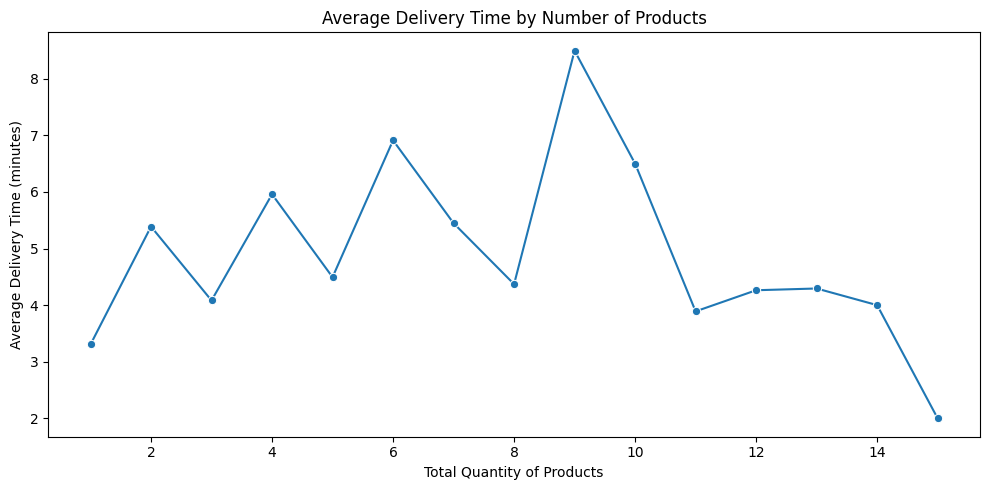

In [31]:
product_avg = stops_df.groupby('total_quantity')['actual_delivery_duration'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=product_avg, x='total_quantity', y='actual_delivery_duration', marker='o')
plt.title('Average Delivery Time by Number of Products')
plt.xlabel('Total Quantity of Products')
plt.ylabel('Average Delivery Time (minutes)')
plt.tight_layout()
plt.show()


We can tell that there is no signifficant correlation between the delivery time and the quantity of products.

#### 4.6. Correlation Matrix

As the last part of the analysis we can plot the correlation matrix, taking into account all the features analysed before. 

In order to do that, we have to map the day of the week back to the numerical values and then select all the necessary columns (*actual_delivery_duration*, *driver_id*, *total_weight*, *total_quantity*, *sector_id*, *weekday*). It will also be necessary to drop the rows containig empty values.

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

weekday_mapping = {
    'Monday': 0, 
    'Tuesday': 1,
    'Wednesday': 2, 
    'Thursday': 3, 
    'Friday': 4,
    'Saturday': 5, 
    'Sunday': 6
}

stops_df['weekday'] = stops_df['weekday'].map(weekday_mapping)

features = stops_df[[
    'actual_delivery_duration',
    'driver_id',
    'total_weight',
    'total_quantity',
    'sector_id',
    'weekday',
]].dropna() 


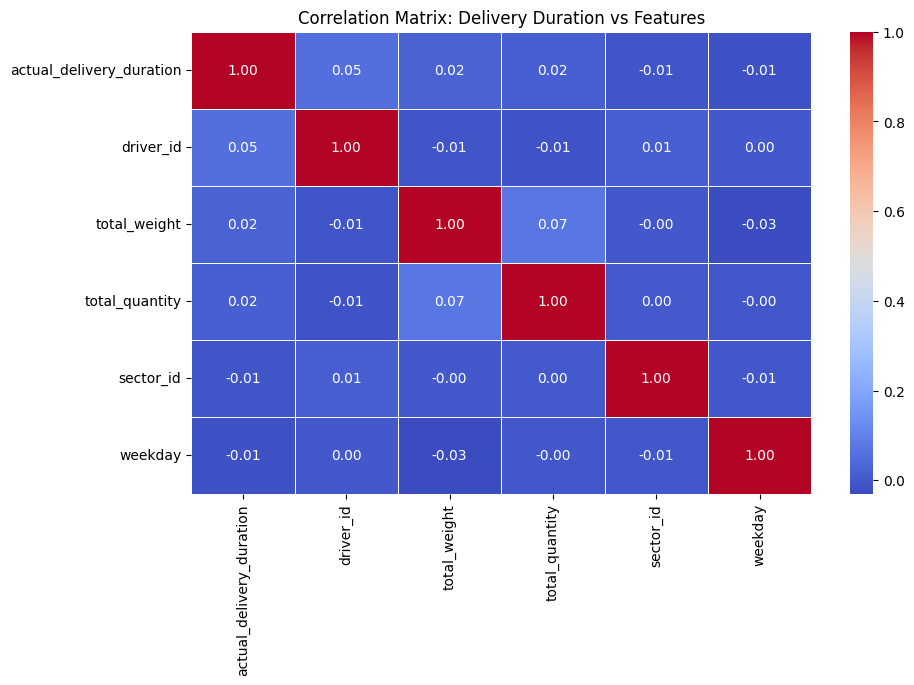

In [33]:
corr_matrix = features.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Delivery Duration vs Features')
plt.show()

We can tell that when it comes to individual features, none of theme influences the delivery time. Probably there are a lot of factors influencing the delivery time all together, meaning that more complex models should be defined. 

To extract more detailed analysis, for instance principal component analysis could be performed.

## Conclusion

**Prediction Accuracy:**  
The current prediction system, based on averages, is fairly accurate for most deliveries, with most predictions falling within ±10 minutes of the actual delivery time. However, there are outliers, indicating that the system could be improved by accounting for more variables.

**Sector Analysis:**  
While sector 3 had a slightly longer average delivery time, the difference was minimal and not statistically significant.

**Driver Variability:**  
Driver 4 consistently took longer for deliveries, which may suggest the need for driver-specific adjustments to prediction models.

**Order Weight and Size:**  
Larger orders do take longer to deliver, but small orders may not always be delivered the fastest. This suggests that other factors, such as delivery route or traffic conditions, could also play significant roles.

**Potential for Improvement:**  
The data does not show a strong, consistent correlation between delivery time and individual features, meaning more complex models considering multiple factors simultaneously could improve prediction accuracy.

This analysis suggests that while the current system works in general, refining the algorithm by considering multiple influencing factors could help reduce prediction errors and improve overall efficiency.